In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from typing import Dict

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Установка стиля графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# 1. ЗАГРУЗКА ДАННЫХ


# Пример:
client_stats = pd.read_csv('C:/Users/Александр/Python/myenv/Lib/site-packages/parso/python/transaction.csv')

# Предполагаем, что client_stats уже загружен (например, из Colab)
logger.info("Данные загружены. Строк: %d, Столбцов: %d", len(client_stats), len(client_stats.columns))

INFO: Данные загружены. Строк: 1008688, Столбцов: 7


In [4]:
def validate_data(df: pd.DataFrame) -> pd.DataFrame:
    required_columns = ['item', 'amount', 'quantity', 'trDte', 'clientID']
    missing = [col for col in required_columns if col not in df.columns]
    if missing:
        raise ValueError(f"❌ Отсутствуют столбцы: {missing}")

    # Конвертация дат
    if not pd.api.types.is_datetime64_any_dtype(df['trDte']):
        df['trDte'] = pd.to_datetime(df['trDte'], errors='coerce')

    # Удаление некорректных дат
    invalid_dates = df['trDte'].isna().sum()
    if invalid_dates > 0:
        logger.warning(f"Удалено {invalid_dates} строк с некорректной датой")
        df = df.dropna(subset=['trDte'])

    # Удаление quantity = 0
    zero_quantity = (df['quantity'] == 0).sum()
    if zero_quantity > 0:
        logger.warning(f"Удалено {zero_quantity} строк с quantity = 0")
        df = df[df['quantity'] > 0]

    # Удаление отрицательных сумм
    df = df[df['amount'] >= 0].copy()

    logger.info(f"✅ Валидация завершена. Осталось строк: {len(df)}")
    return df

client_stats = validate_data(client_stats)

INFO: ✅ Валидация завершена. Осталось строк: 392339


In [5]:
# 3. ФИЛЬТРАЦИЯ: последние 6 месяцев
# ———————————————————————————————————————

start_date = '2019-05-01'
end_date = '2019-10-31'
df_recent = client_stats[
    (client_stats['trDte'] >= start_date) &
    (client_stats['trDte'] <= end_date)
].copy()

logger.info(f"Фильтрация: {len(df_recent)} строк за 6 месяцев")

INFO: Фильтрация: 105958 строк за 6 месяцев


In [7]:
# 4. ABC-XYZ АНАЛИЗ
# ———————————————————————————————————————

def abc_xyz_analysis(df: pd.DataFrame, abc_a: float = 80.0, abc_b: float = 95.0) -> pd.DataFrame:
    logger.info("Запуск ABC-XYZ анализа...")

    # ABC: по выручке
    abc = (df.groupby('item', as_index=False)['amount']
           .sum()
           .sort_values('amount', ascending=False)
           .reset_index(drop=True))
    abc['cumulative_pct'] = abc['amount'].cumsum() / abc['amount'].sum() * 100

    abc['ABC_group'] = pd.cut(
        abc['cumulative_pct'],
        bins=[0, abc_a, abc_b, 100],
        labels=['A', 'B', 'C'],
        include_lowest=True
    ).astype(str)

    # XYZ: по стабильности количества
    xyz_raw = df.groupby('item')['quantity'].agg(['mean', 'std', 'count']).reset_index()
    xyz_raw = xyz_raw[xyz_raw['count'] > 1]
    xyz_raw['std'] = xyz_raw['std'].fillna(0)
    xyz_raw['CV'] = (xyz_raw['std'] / xyz_raw['mean']) * 100
    xyz_raw['CV'] = xyz_raw['CV'].replace([np.inf, -np.inf], 100)

    xyz_raw['XYZ_group'] = pd.cut(
        xyz_raw['CV'],
        bins=[0, 15, 25, 100],
        labels=['X', 'Y', 'Z'],
        include_lowest=True
    ).astype(str)

    result = abc[['item', 'ABC_group']].merge(
        xyz_raw[['item', 'XYZ_group']],
        on='item',
        how='inner'
    )
    result['combined_group'] = result['ABC_group'] + result['XYZ_group']
    return result

full_results = abc_xyz_analysis(client_stats)
recent_results = abc_xyz_analysis(df_recent)

INFO: Запуск ABC-XYZ анализа...
INFO: Запуск ABC-XYZ анализа...


In [8]:
# 5. СРАВНЕНИЕ ПЕРИОДОВ
# ———————————————————————————————————————

def compare_groups(base: pd.DataFrame, recent: pd.DataFrame) -> pd.DataFrame:
    merged = base.merge(recent, on='item', how='inner', suffixes=('_base', '_recent'))
    merged['changed'] = merged['combined_group_base'] != merged['combined_group_recent']

    rank = {'A': 3, 'B': 2, 'C': 1}
    merged['rank_base'] = merged['ABC_group_base'].map(rank)
    merged['rank_recent'] = merged['ABC_group_recent'].map(rank)
    merged['trend'] = np.where(
        merged['rank_recent'] > merged['rank_base'], '↑ Улучшился',
        np.where(merged['rank_recent'] < merged['rank_base'], '↓ Ухудшился', '→ Без изменений')
    )
    return merged

comparison = compare_groups(full_results, recent_results)

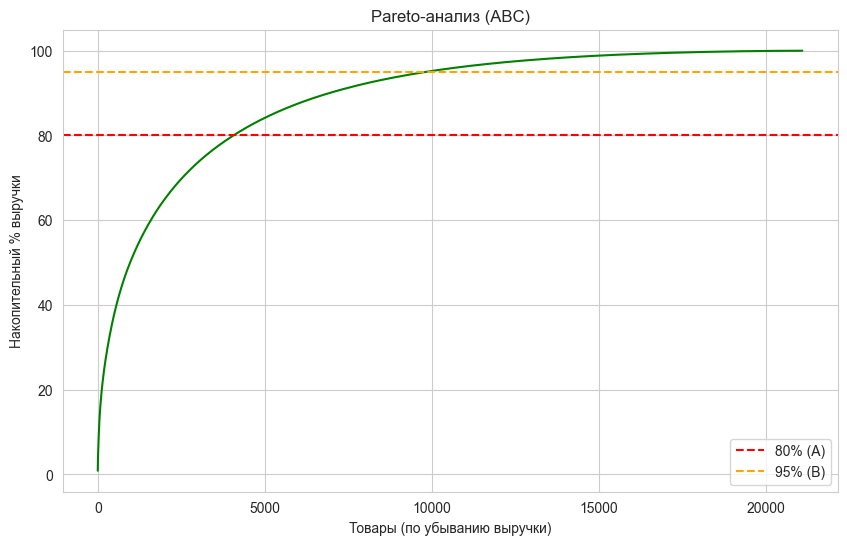

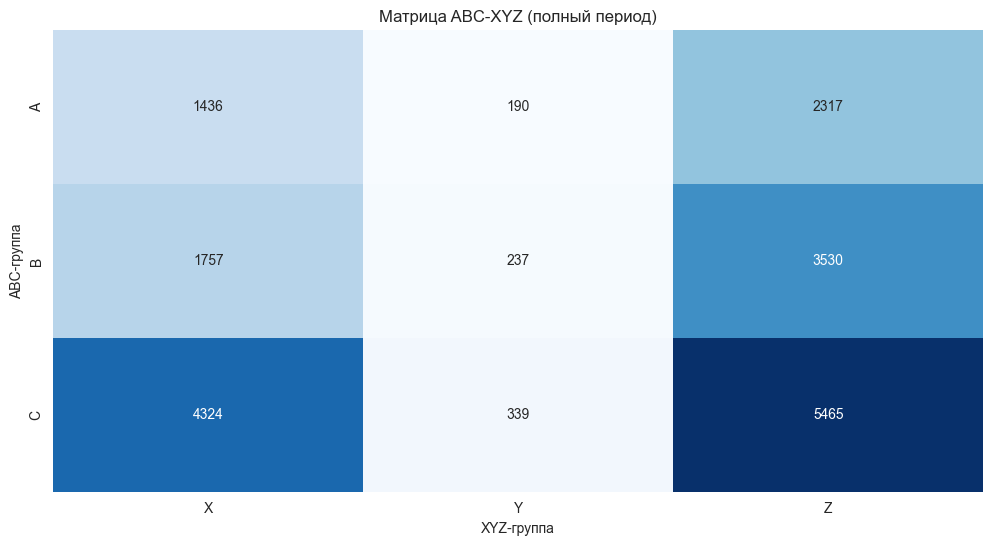

In [9]:
# 6. ВИЗУАЛИЗАЦИЯ
# ———————————————————————————————————————

# Pareto-чарт
plt.figure(figsize=(10, 6))
amount_sorted = full_results.merge(
    client_stats.groupby('item')['amount'].sum(), on='item'
).sort_values('amount', ascending=False)

cum_pct = amount_sorted['amount'].cumsum().div(amount_sorted['amount'].sum()).mul(100)
sns.lineplot(x=range(len(cum_pct)), y=cum_pct, color='green')
plt.axhline(80, color='red', linestyle='--', label='80% (A)')
plt.axhline(95, color='orange', linestyle='--', label='95% (B)')
plt.title("Pareto-анализ (ABC)")
plt.xlabel("Товары (по убыванию выручки)")
plt.ylabel("Накопительный % выручки")
plt.legend()
plt.show()

# Тепловая карта ABC-XYZ
matrix = pd.crosstab(full_results['ABC_group'], full_results['XYZ_group']
                    ).reindex(index=['A','B','C'], columns=['X','Y','Z'], fill_value=0)
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Матрица ABC-XYZ (полный период)")
plt.ylabel("ABC-группа")
plt.xlabel("XYZ-группа")
plt.show()

In [10]:
# 7. ЭКСПОРТ В CSV
# ———————————————————————————————————————

def export_results(df: pd.DataFrame, filename: str, desc: str):
    df.to_csv(filename, index=False)
    logger.info(f"✅ {desc} → {filename}")
    display(df.head())

# ТОП-5
top_5 = (client_stats.groupby('item')['amount'].sum()
         .sort_values(ascending=False).head(5).reset_index())
export_results(top_5, 'top_5_products.csv', 'ТОП-5 товаров')

# Статистика по клиентам
client_summary = client_stats.groupby('clientID').agg(  # ← Изменено с client_id на clientID
    total_visits=('trDte', 'count'),       # ← Изменено с visit_date на trDte
    total_spent=('amount', 'sum'),
    avg_check=('amount', 'mean'),
    avg_quantity=('quantity', 'mean')
).round(2).reset_index()
export_results(client_summary, 'client_statistics.csv', 'Статистика по клиентам')

# ABC и XYZ
export_results(full_results[['item', 'ABC_group']], 'abc_analysis.csv', 'ABC-анализ')
export_results(recent_results[['item', 'XYZ_group']], 'xyz_analysis.csv', 'XYZ-анализ')

# Матрица
matrix_reset = matrix.reset_index()
export_results(matrix_reset, 'abc_xyz_matrix.csv', 'Матрица ABC-XYZ')

# Данные за 6 мес
export_results(df_recent, 'last_6_months_data.csv', 'Данные за последние 6 месяцев')

INFO: ✅ ТОП-5 товаров → top_5_products.csv


,item,amount
0,sku26161,1990719
1,sku18199,1558121
2,sku21947,1406811
3,sku28128,1167984
4,sku8342,896869


INFO: ✅ Статистика по клиентам → client_statistics.csv


,clientID,total_visits,total_spent,avg_check,avg_quantity
0,client10,3,4757,1585.67,1.00
1,client100,1,7299,7299.00,1.00
2,client1000,14,16321,1165.79,7.36
3,client10000,5,8495,1699.00,1.00
4,client10001,1,179,179.00,1.00


INFO: ✅ ABC-анализ → abc_analysis.csv


,item,ABC_group
0,sku26161,A
1,sku18199,A
2,sku21947,A
3,sku28128,A
4,sku8342,A


INFO: ✅ XYZ-анализ → xyz_analysis.csv


,item,XYZ_group
0,sku26161,nan
1,sku8342,nan
2,sku18199,nan
3,sku21947,Z
4,sku22208,Y


INFO: ✅ Матрица ABC-XYZ → abc_xyz_matrix.csv


XYZ_group,ABC_group,X,Y,Z
0,A,1436,190,2317
1,B,1757,237,3530
2,C,4324,339,5465


INFO: ✅ Данные за последние 6 месяцев → last_6_months_data.csv


,trDte,bcode,clientID,item,itemGroup,quantity,amount
459826,2019-05-01,code000129711,client22949,sku20800,Сантехника,1,299
459827,2019-05-01,code000129712,client36961,sku29907,Стойматериалы,4,876
459828,2019-05-01,code000129713,client37688,sku22559,Скобяные изделия,1,25
459829,2019-05-01,code000129713,client37688,sku30465,Скобяные изделия,1,25
459830,2019-05-01,code000129713,client37688,sku3336,Скобяные изделия,2,78


In [11]:
# 8. ИТОГИ
# ———————————————————————————————————————

print("\n" + "="*60)
print("📊 ИТОГОВЫЙ ОТЧЁТ")
print("="*60)

print(f"🔹 Всего уникальных товаров: {client_stats['item'].nunique()}")
print(f"🔹 Товары в обоих периодах: {len(comparison)}")
print(f"🔹 Сменили группу: {comparison['changed'].sum()}")

improved = comparison[comparison['trend'] == '↑ Улучшился']
declined = comparison[comparison['trend'] == '↓ Ухудшился']

print(f"🔹 Улучшили позиции: {len(improved)}")
print(f"🔹 Ухудшили позиции: {len(declined)}")

if len(improved) > 0:
    print("\nТОП-5 улучшившихся:")
    display(improved[['item', 'ABC_group_base', 'ABC_group_recent', 'trend']].head())

if len(declined) > 0:
    print("\nТОП-5 ухудшившихся:")
    display(declined[['item', 'ABC_group_base', 'ABC_group_recent', 'trend']].head())


📊 ИТОГОВЫЙ ОТЧЁТ
🔹 Всего уникальных товаров: 26220
🔹 Товары в обоих периодах: 11703
🔹 Сменили группу: 4729
🔹 Улучшили позиции: 611
🔹 Ухудшили позиции: 1662

ТОП-5 улучшившихся:


,item,ABC_group_base,ABC_group_recent,trend
2953,sku12194,B,A,↑ Улучшился
2955,sku29164,B,A,↑ Улучшился
2958,sku5566,B,A,↑ Улучшился
2969,sku21970,B,A,↑ Улучшился
2970,sku19647,B,A,↑ Улучшился



ТОП-5 ухудшившихся:


,item,ABC_group_base,ABC_group_recent,trend
201,sku6216,A,B,↓ Ухудшился
301,sku26165,A,B,↓ Ухудшился
357,sku26407,A,B,↓ Ухудшился
361,sku18018,A,B,↓ Ухудшился
402,sku24899,A,B,↓ Ухудшился
